In [22]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [47]:
latent_dim = 64
in_channels = 1
im_size = (28,28)
batch_size = 64
num_epochs = 50
num_samples = 225
nrows = 15

In [4]:
class Generator(nn.Module):
    def __init__ (self):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim
        self.im_size = im_size
        self.in_channels = in_channels
        activation = nn.LeakyReLU()
        layers_dim = [self.latent_dim, 128, 256, 512, self.im_size[0]*self.im_size[1]*self.in_channels]
        
        self.layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(layers_dim[i], layers_dim[i+1]),
                    nn.BatchNorm1d(layers_dim[i+1]) if i!= len(layers_dim)-2 else nn.Identity(),
                    activation if i!= len(layers_dim)-2 else nn.Sigmoid()
                )
                for i in range(len(layers_dim)-1)
            ]
        )

    def forward(self, z):
        batch_size = z.size(0)
        out = z.reshape(-1, self.latent_dim)
        for layer in self.layers:
            out = layer(out)
        return out.view(-1, self.in_channels, self.im_size[0], self.im_size[1])

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.im_size = im_size
        self.in_channels = in_channels
        activation = nn.LeakyReLU()
        layers_dim = [self.im_size[0]*self.im_size[1]*self.in_channels, 512, 256, 128, 1]
        self.layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(layers_dim[i], layers_dim[i+1]),
                    nn.LayerNorm(layers_dim[i+1]) if i!= len(layers_dim)-2 else nn.Identity(),
                    activation if i!= len(layers_dim)-2 else nn.Identity()
                )
                for i in range(len(layers_dim)-1)
            ]
        )

    def forward(self, x):
        out = x.reshape(-1, self.im_size[0]*self.im_size[1]*self.in_channels)
        for layer in self.layers:
            out = layer(out)
        return out

In [48]:
def train():
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    generator.train()
    discriminator.train()

    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    criterion = nn.BCEWithLogitsLoss()

    steps = 0
    generated_sample_count = 0

    for epoch in tqdm(range(num_epochs)):
        for im, _ in tqdm(train_loader):
            real_ims = im.float().to(device)
            batch_size = real_ims.shape[0]

            # optimize discriminator
            optimizer_discriminator.zero_grad()
            fake_im_noise = torch.randn(batch_size, latent_dim).to(device)
            fake_ims = generator(fake_im_noise)
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            disc_real_pred = discriminator(real_ims)
            disc_fake_pred = discriminator(fake_ims.detach())
            disc_real_loss = criterion(disc_real_pred.reshape(-1), real_labels.reshape(-1))
            disc_fake_loss = criterion(disc_fake_pred.reshape(-1), fake_labels.reshape(-1))
            disc_loss = (disc_real_loss + disc_fake_loss)/2
            disc_loss.backward()
            optimizer_discriminator.step()

            # optimize generator
            optimizer_generator.zero_grad()
            fake_im_noise = torch.randn(batch_size, latent_dim).to(device)
            fake_ims = generator(fake_im_noise)
            disc_fake_pred = discriminator(fake_ims)
            gen_fake_loss = criterion(disc_fake_pred.reshape(-1), real_labels.reshape(-1))
            gen_fake_loss.backward()
            optimizer_generator.step()
        
        print(f"Epoch {epoch+1}/{num_epochs} | Discriminator Loss: {disc_loss.item()} | Generator Loss: {gen_fake_loss.item()}")

    return generator

In [12]:
# load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [49]:
generator = train()

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:14<11:51, 14.52s/it]

Epoch 1/50 | Discriminator Loss: 0.007759703788906336 | Generator Loss: 5.405104637145996


  4%|▍         | 2/50 [00:28<11:28, 14.34s/it]

Epoch 2/50 | Discriminator Loss: 0.017258208245038986 | Generator Loss: 4.690821647644043


  6%|▌         | 3/50 [00:43<11:15, 14.37s/it]

Epoch 3/50 | Discriminator Loss: 0.0288988184183836 | Generator Loss: 4.7812418937683105


  8%|▊         | 4/50 [00:57<11:01, 14.37s/it]

Epoch 4/50 | Discriminator Loss: 0.13015279173851013 | Generator Loss: 3.6027207374572754


 10%|█         | 5/50 [01:12<10:48, 14.42s/it]

Epoch 5/50 | Discriminator Loss: 0.20444729924201965 | Generator Loss: 5.076511383056641


 12%|█▏        | 6/50 [01:26<10:34, 14.41s/it]

Epoch 6/50 | Discriminator Loss: 0.07633404433727264 | Generator Loss: 3.284623384475708


 14%|█▍        | 7/50 [01:40<10:19, 14.40s/it]

Epoch 7/50 | Discriminator Loss: 0.13369327783584595 | Generator Loss: 2.902707576751709


 16%|█▌        | 8/50 [01:55<10:04, 14.38s/it]

Epoch 8/50 | Discriminator Loss: 0.13297712802886963 | Generator Loss: 2.9078683853149414


 18%|█▊        | 9/50 [02:09<09:49, 14.38s/it]

Epoch 9/50 | Discriminator Loss: 0.1401464194059372 | Generator Loss: 2.6674036979675293


 20%|██        | 10/50 [02:23<09:34, 14.35s/it]

Epoch 10/50 | Discriminator Loss: 0.2147810459136963 | Generator Loss: 2.9455697536468506


 22%|██▏       | 11/50 [02:38<09:20, 14.37s/it]

Epoch 11/50 | Discriminator Loss: 0.25131744146347046 | Generator Loss: 2.191164016723633


 22%|██▏       | 11/50 [02:40<09:28, 14.59s/it]


KeyboardInterrupt: 

In [18]:
# save model
torch.save(generator.state_dict(), "aq_final.pth")

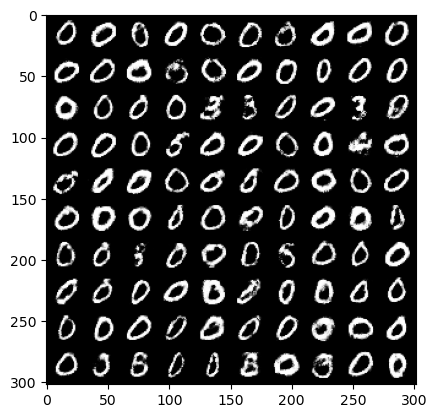

In [50]:
# sample 64 images
generator = Generator().to(device)
generator.load_state_dict(torch.load("aq_final.pth"))
generator.eval()
noise = torch.randn(100, latent_dim).to(device)
generated_ims = generator(noise)
generated_ims = generated_ims.view(-1, 1, 28, 28).detach().cpu()
grid = torchvision.utils.make_grid(generated_ims, nrow=10, padding=2, normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.show()